# Annolid on Detectron2 Tutorial 2 : Train a Model

This is modified from the official colab tutorial of detectron2. Here, we will 

* Train (fine-tune) a detectron2 model on our dataset.

You can make a copy of this tutorial by "File -> Open in playground mode" and play with it yourself. __DO NOT__ request access to this tutorial.


In [1]:
# Is running in colab or in jupyter-notebook
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [2]:
# install dependencies: 
!pip install pyyaml==5.3
import torch, torchvision
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


torch:  1.10 ; cuda:  cu102


Defaulting to user installation because normal site-packages is not writeable


Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.10/index.html


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
# import some common libraries
import json
import os
import cv2
import random
import glob
import numpy as np
if IN_COLAB:
  from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [5]:
# is there a gpu
if torch.cuda.is_available():
    GPU = True
    print('gpu available')
else:
    GPU = False
    print('no gpu')

gpu available


# Train on a custom dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in COCO format.

## Prepare the dataset

## Upload a labeled dataset.
The following code is expecting the dataset in the COCO format to be in a ***.zip*** file. For example: ```sample_dataset.zip``` \
Note: please make sure there is no white space in your file path if you encounter file not found issues.

In [6]:
!pip install gdown 
!gdown --id 1fUXCLnoJ5SwXg54mj0NBKGzidsV8ALVR

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


/home/jeremy/.local/lib/python3.8/site-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(


Downloading...
From: https://drive.google.com/uc?id=1fUXCLnoJ5SwXg54mj0NBKGzidsV8ALVR
To: /home/jeremy/Documents/annolid/book/tutorials/novelctrlk6_8_coco_dataset.zip
  0%|                                               | 0.00/10.3M [00:00<?, ?B/s]

100%|██████████████████████████████████████| 10.3M/10.3M [00:00<00:00, 94.6MB/s]


In [7]:
if IN_COLAB:
    dataset = '/content/novelctrlk6_8_coco_dataset.zip'
else:
    dataset = 'novelctrlk6_8_coco_dataset.zip'

In [8]:
if IN_COLAB:
    !unzip $dataset -d /content/
else:
    #TODO generalize this
    !unzip -o $dataset -d .

Archive:  novelctrlk6_8_coco_dataset.zip
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00001416_41.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00004233_81.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00004515_22.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00000636_6.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00006297_11.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00006818_79.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00006056_25.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00006094_12.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00004340_96.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00000557_50.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00000979_94.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00005018_19.jpg  
  inflating: ./novelctrlk6_8_coco_da

  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00000842_70.jpg  
  inflating: ./__MACOSX/novelctrlk6_8_coco_dataset/train/JPEGImages/._00000842_70.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00002295_32.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00004117_59.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00003976_44.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00004032_20.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006212_69.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00003134_31.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006169_98.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006830_36.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00004570_24.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00000735_23.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/000039

In [9]:
DATASET_NAME = DATASET_DIR = f"{dataset.replace('.zip','')}"

Register the custom dataset to Detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).
Here, the dataset is in COCO format, therefore we register  into Detectron2's standard format. User should write such a function when using a dataset in custom format. See the tutorial for more details.


In [10]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import get_detection_dataset_dicts
from detectron2.data.datasets import  builtin_meta

In [11]:
register_coco_instances(f"{DATASET_NAME}_train", {}, f"{DATASET_DIR}/train/annotations.json", f"{DATASET_DIR}/train/")
register_coco_instances(f"{DATASET_NAME}_valid", {}, f"{DATASET_DIR}/valid/annotations.json", f"{DATASET_DIR}/valid/")

In [12]:
dataset_dicts = get_detection_dataset_dicts([f"{DATASET_NAME}_train"])

[05/03 10:10:51 d2.data.datasets.coco]: Loaded 118 images in COCO format from novelctrlk6_8_coco_dataset/train/annotations.json


[05/03 10:10:51 d2.data.build]: Removed 0 images with no usable annotations. 118 images left.


[05/03 10:10:51 d2.data.build]: Distribution of instances among all 7 categories:
|   category   | #instances   |  category  | #instances   |  category  | #instances   |
|:------------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| _background_ | 0            |    nose    | 118          |  left_ear  | 118          |
|  right_ear   | 117          | tail_base  | 119          |   mouse    | 118          |
|   centroid   | 1            |            |              |            |              |
|    total     | 591          |            |              |            |              |


In [13]:
_dataset_metadata = MetadataCatalog.get(f"{DATASET_NAME}_train")
_dataset_metadata.thing_colors = [cc['color'] for cc in builtin_meta.COCO_CATEGORIES]

In [14]:
_dataset_metadata

namespace(name='novelctrlk6_8_coco_dataset_train',
          json_file='novelctrlk6_8_coco_dataset/train/annotations.json',
          image_root='novelctrlk6_8_coco_dataset/train/',
          evaluator_type='coco',
          thing_classes=['_background_',
                         'nose',
                         'left_ear',
                         'right_ear',
                         'tail_base',
                         'mouse',
                         'centroid'],
          thing_dataset_id_to_contiguous_id={0: 0,
                                             1: 1,
                                             2: 2,
                                             3: 3,
                                             4: 4,
                                             5: 5,
                                             6: 6},
          thing_colors=[[220, 20, 60],
                        [119, 11, 32],
                        [0, 0, 142],
                        [0, 0, 230],
                

In [15]:
NUM_CLASSES = len(_dataset_metadata.thing_classes)
print(f"{NUM_CLASSES} Number of classes in the dataset")

7 Number of classes in the dataset


To verify the data loading is correct, let's visualize the annotations of a randomly selected sample in the training set:



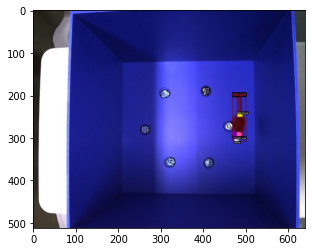

In [16]:
for d in random.sample(dataset_dicts, 2):
    if '\\' in d['file_name']:
        d['file_name'] = d['file_name'].replace('\\','/')
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=_dataset_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    if IN_COLAB:
        cv2_imshow(out.get_image()[:, :, ::-1])
    else:
        plt.imshow(out.get_image()[:, :, ::-1])
        

## Train!

Now, let's fine-tune the COCO-pretrained R50-FPN Mask R-CNN model with our custom dataset. It takes ~2 hours to train 3000 iterations on Colab's K80 GPU, or ~1.5 hours on a P100 GPU.


In [17]:
if GPU:
    !nvidia-smi

Tue May  3 10:10:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:C1:00.0  On |                  N/A |
| 24%   37C    P8    23W / 250W |   7818MiB /  7979MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [18]:
from detectron2.engine import DefaultTrainer

In [19]:
cfg = get_cfg()

In [20]:
if GPU:
    pass
else:
    cfg.MODEL.DEVICE='cpu'

In [21]:
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (f"{DATASET_NAME}_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2 #@param
cfg.DATALOADER.SAMPLER_TRAIN = "RepeatFactorTrainingSampler"
cfg.DATALOADER.REPEAT_THRESHOLD = 0.3
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH =  4 #@param
cfg.SOLVER.BASE_LR = 0.0025 #@param # pick a good LR
cfg.SOLVER.MAX_ITER = 3000 #@param    # 300 iterations seems good enough for 100 frames dataset; you will need to train longer for a practical dataset
cfg.SOLVER.CHECKPOINT_PERIOD = 1000 #@param 
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 32 #@param   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES  #  (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [22]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

Reusing TensorBoard on port 6007 (pid 153647), started 3 days, 1:03:08 ago. (Use '!kill 153647' to kill it.)

In [23]:
trainer.train()

[01/24 12:59:41 d2.engine.train_loop]: Starting training from iteration 0


/home/jeremy/anaconda3/envs/annolid-env/lib/python3.7/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/jeremy/anaconda3/envs/annolid-env/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[01/24 12:59:49 d2.utils.events]:  eta: 0:21:30  iter: 19  total_loss: 5.746  loss_cls: 2.05  loss_box_reg: 0.7793  loss_mask: 0.6885  loss_rpn_cls: 1.848  loss_rpn_loc: 0.3801  time: 0.4068  data_time: 0.0162  lr: 4.9952e-05  max_mem: 3599M
[01/24 12:59:56 d2.utils.events]:  eta: 0:18:17  iter: 39  total_loss: 3.158  loss_cls: 1.374  loss_box_reg: 0.8234  loss_mask: 0.6686  loss_rpn_cls: 0.06725  loss_rpn_loc: 0.2583  time: 0.3941  data_time: 0.0078  lr: 9.9902e-05  max_mem: 3599M
[01/24 13:00:04 d2.utils.events]:  eta: 0:18:10  iter: 59  total_loss: 2.673  loss_cls: 0.9473  loss_box_reg: 0.836  loss_mask: 0.6551  loss_rpn_cls: 0.04344  loss_rpn_loc: 0.1974  time: 0.3931  data_time: 0.0070  lr: 0.00014985  max_mem: 3599M
[01/24 13:00:13 d2.utils.events]:  eta: 0:21:04  iter: 79  total_loss: 2.518  loss_cls: 0.8533  loss_box_reg: 0.8565  loss_mask: 0.6405  loss_rpn_cls: 0.03807  loss_rpn_loc: 0.1586  time: 0.4006  data_time: 0.0078  lr: 0.0001998  max_mem: 3599M
[01/24 13:00:21 d2.util

[01/24 13:04:16 d2.utils.events]:  eta: 0:16:48  iter: 679  total_loss: 1.246  loss_cls: 0.2001  loss_box_reg: 0.5117  loss_mask: 0.3799  loss_rpn_cls: 0.006953  loss_rpn_loc: 0.1028  time: 0.4039  data_time: 0.0072  lr: 0.0016983  max_mem: 3599M
[01/24 13:04:24 d2.utils.events]:  eta: 0:16:37  iter: 699  total_loss: 1.182  loss_cls: 0.1981  loss_box_reg: 0.5156  loss_mask: 0.3698  loss_rpn_cls: 0.005824  loss_rpn_loc: 0.08289  time: 0.4038  data_time: 0.0079  lr: 0.0017483  max_mem: 3599M
[01/24 13:04:32 d2.utils.events]:  eta: 0:16:31  iter: 719  total_loss: 1.16  loss_cls: 0.184  loss_box_reg: 0.477  loss_mask: 0.3763  loss_rpn_cls: 0.009227  loss_rpn_loc: 0.09665  time: 0.4039  data_time: 0.0077  lr: 0.0017982  max_mem: 3599M
[01/24 13:04:40 d2.utils.events]:  eta: 0:16:23  iter: 739  total_loss: 1.207  loss_cls: 0.1747  loss_box_reg: 0.4921  loss_mask: 0.3792  loss_rpn_cls: 0.007379  loss_rpn_loc: 0.1228  time: 0.4040  data_time: 0.0080  lr: 0.0018482  max_mem: 3599M
[01/24 13:04:

[01/24 13:08:47 d2.utils.events]:  eta: 0:12:17  iter: 1339  total_loss: 0.9168  loss_cls: 0.1201  loss_box_reg: 0.3791  loss_mask: 0.3526  loss_rpn_cls: 0.007066  loss_rpn_loc: 0.06937  time: 0.4069  data_time: 0.0076  lr: 0.0025  max_mem: 3599M
[01/24 13:08:55 d2.utils.events]:  eta: 0:12:08  iter: 1359  total_loss: 0.9252  loss_cls: 0.1088  loss_box_reg: 0.3694  loss_mask: 0.3321  loss_rpn_cls: 0.007251  loss_rpn_loc: 0.07654  time: 0.4067  data_time: 0.0074  lr: 0.0025  max_mem: 3599M
[01/24 13:09:03 d2.utils.events]:  eta: 0:11:59  iter: 1379  total_loss: 0.9791  loss_cls: 0.1147  loss_box_reg: 0.3836  loss_mask: 0.3581  loss_rpn_cls: 0.007708  loss_rpn_loc: 0.08671  time: 0.4068  data_time: 0.0080  lr: 0.0025  max_mem: 3599M
[01/24 13:09:12 d2.utils.events]:  eta: 0:11:51  iter: 1399  total_loss: 0.899  loss_cls: 0.1194  loss_box_reg: 0.3629  loss_mask: 0.3435  loss_rpn_cls: 0.005933  loss_rpn_loc: 0.1211  time: 0.4069  data_time: 0.0078  lr: 0.0025  max_mem: 3599M
[01/24 13:09:2

[01/24 13:13:16 d2.utils.events]:  eta: 0:07:25  iter: 1999  total_loss: 0.8048  loss_cls: 0.07482  loss_box_reg: 0.3065  loss_mask: 0.3102  loss_rpn_cls: 0.004048  loss_rpn_loc: 0.09146  time: 0.4066  data_time: 0.0078  lr: 0.0025  max_mem: 3599M
[01/24 13:13:24 d2.utils.events]:  eta: 0:07:16  iter: 2019  total_loss: 0.7888  loss_cls: 0.06711  loss_box_reg: 0.297  loss_mask: 0.3241  loss_rpn_cls: 0.004265  loss_rpn_loc: 0.08338  time: 0.4067  data_time: 0.0082  lr: 0.0025  max_mem: 3599M
[01/24 13:13:32 d2.utils.events]:  eta: 0:07:07  iter: 2039  total_loss: 0.8322  loss_cls: 0.09426  loss_box_reg: 0.3311  loss_mask: 0.3144  loss_rpn_cls: 0.004307  loss_rpn_loc: 0.05577  time: 0.4067  data_time: 0.0078  lr: 0.0025  max_mem: 3599M
[01/24 13:13:41 d2.utils.events]:  eta: 0:06:58  iter: 2059  total_loss: 0.7891  loss_cls: 0.08497  loss_box_reg: 0.301  loss_mask: 0.3115  loss_rpn_cls: 0.005715  loss_rpn_loc: 0.05674  time: 0.4068  data_time: 0.0092  lr: 0.0025  max_mem: 3599M
[01/24 13:

[01/24 13:17:38 d2.utils.events]:  eta: 0:02:17  iter: 2639  total_loss: 0.7367  loss_cls: 0.06714  loss_box_reg: 0.2739  loss_mask: 0.3024  loss_rpn_cls: 0.005877  loss_rpn_loc: 0.06885  time: 0.4071  data_time: 0.0081  lr: 0.0025  max_mem: 3599M
[01/24 13:17:46 d2.utils.events]:  eta: 0:02:20  iter: 2659  total_loss: 0.7465  loss_cls: 0.05305  loss_box_reg: 0.2743  loss_mask: 0.3195  loss_rpn_cls: 0.004345  loss_rpn_loc: 0.08189  time: 0.4072  data_time: 0.0079  lr: 0.0025  max_mem: 3599M
[01/24 13:17:55 d2.utils.events]:  eta: 0:02:22  iter: 2679  total_loss: 0.736  loss_cls: 0.05752  loss_box_reg: 0.2565  loss_mask: 0.3142  loss_rpn_cls: 0.005848  loss_rpn_loc: 0.07894  time: 0.4073  data_time: 0.0080  lr: 0.0025  max_mem: 3599M
[01/24 13:18:03 d2.utils.events]:  eta: 0:01:55  iter: 2699  total_loss: 0.7671  loss_cls: 0.0624  loss_box_reg: 0.2683  loss_mask: 0.3052  loss_rpn_cls: 0.004146  loss_rpn_loc: 0.07695  time: 0.4072  data_time: 0.0079  lr: 0.0025  max_mem: 3599M
[01/24 13:

## Save and download the trained model weights

In [24]:
final_model_file = os.path.join(cfg.OUTPUT_DIR,'model_final.pth')

In [25]:
if IN_COLAB:
    from google.colab import files
    files.download(final_model_file)
else:
    from IPython.display import FileLink
    FileLink(final_model_file)